## Setup and Imports

In [22]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
print(f"Using device: {device}")

Using device: cuda


In [23]:
LEARNING_RATE = 0.0005
BATCH_SIXE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 10
FEATURE_CRITIC = 64
FEATURE_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01


## The Critic

In [24]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic,self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d , kernel_size = 4, stride =2,
            padding = 1),
            nn.LeakyReLU(0.2),  
            self._block(features_d , features_d*2,4,2,1),
            self._block(features_d*2, features_d*4,4,2,1),
            self._block(features_d*4, features_d*8,4,2,1),

            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0)
        )

    def _block(self,in_channels,out_channels , kernel_size =4, stride =2 , padding = 0):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self,x):
        return self.critic(x)
    

## The Generator

In [25]:
class Generator(nn.Module):
    def __init__(self,z_dim,channels_img , features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim , features_g * 16 , 4,1,0),
            self._block(features_g * 16 , features_g * 8,4,2,1),
            self._block(features_g * 8 , features_g * 4,4,2,1),
            self._block(features_g * 4 , features_g * 2,4,2,1),

            nn.ConvTranspose2d(features_g *2 , channels_img , kernel_size =4 , 
            stride = 2 , padding = 1),
            nn.Tanh()
        )

    def _block(self,in_channels, out_channels , kernel_size =4 , stride =2, padding = 0):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels , out_channels , 
            kernel_size , stride , padding , bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

        )

    def forward(self,x):
        return self.gen(x)


## Initialization & Data Loading

In [26]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURE_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURE_CRITIC).to(device)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d , nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)

gen.apply(initialize_weights)
critic.apply(initialize_weights)

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5],[0.5]
            ),
    ])

dataset = torchvision.datasets.MNIST(root = "dataset/",transform = transforms , download = True)
loader = DataLoader(dataset , batch_size = BATCH_SIXE , shuffle = True)

opt_gen = optim.RMSprop(gen.parameters() , lr = LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters() , lr = LEARNING_RATE)



100%|██████████| 9.91M/9.91M [02:11<00:00, 75.7kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 51.0kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 293kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.66MB/s]


## Training Loop

In [ ]:
fixed_noise = torch.randn(32 , Z_DIM , 1 , 1).to(device)
print("Starting Training ...")

for epoch in range(NUM_EPOCHS):
    for batch_idx , (real , _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size , Z_DIM , 1 , 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))

            opt_critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP , WEIGHT_CLIP)

        gen_fake = critic(fake).reshape(-1)

        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                Loss C: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )   



Starting Training ...
Epoch [0/10] Batch 0/938                 Loss C: -0.9402, loss G: 0.5156
Epoch [0/10] Batch 100/938                 Loss C: -0.7719, loss G: 0.3807
Epoch [0/10] Batch 200/938                 Loss C: -0.9140, loss G: 0.5532
Epoch [0/10] Batch 300/938                 Loss C: -0.7928, loss G: 0.2984
Epoch [0/10] Batch 400/938                 Loss C: -0.8096, loss G: 0.5617
Epoch [0/10] Batch 500/938                 Loss C: -0.5913, loss G: 0.0523
Epoch [0/10] Batch 600/938                 Loss C: -0.7353, loss G: 0.5530
Epoch [0/10] Batch 700/938                 Loss C: -0.7286, loss G: 0.0778
Epoch [0/10] Batch 800/938                 Loss C: -0.5502, loss G: 0.5488
Epoch [0/10] Batch 900/938                 Loss C: -0.6992, loss G: 0.0339
Epoch [1/10] Batch 0/938                 Loss C: -0.4573, loss G: 0.0595
Epoch [1/10] Batch 100/938                 Loss C: -0.4564, loss G: 0.5591
Epoch [1/10] Batch 200/938                 Loss C: -0.4419, loss G: 0.5296
Epoch [

## Generating Output

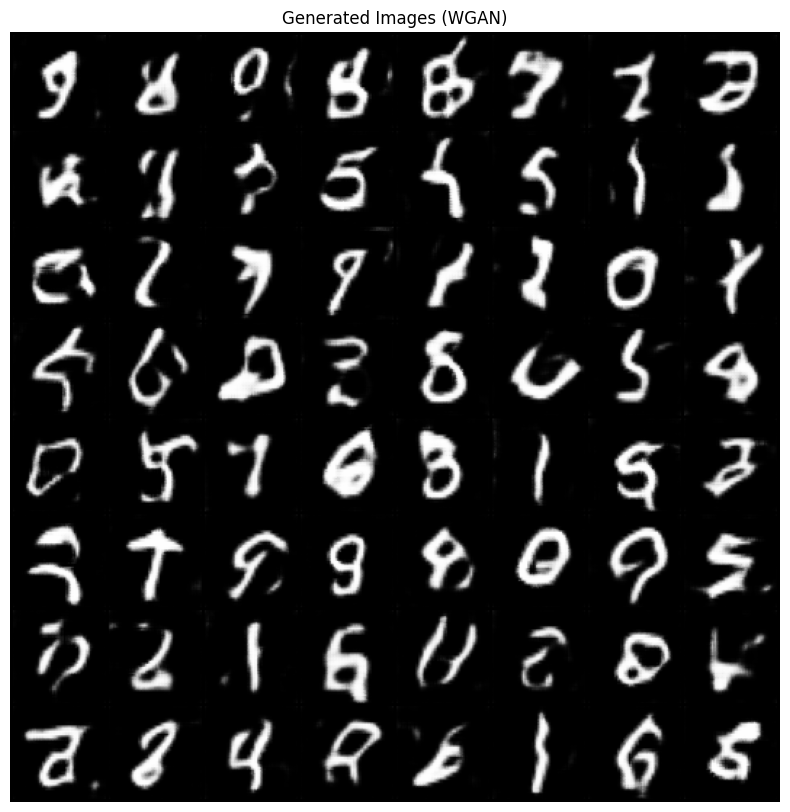

In [32]:
import matplotlib.pyplot as plt
import torchvision

# 1. Switch to evaluation mode (turns off BatchNorm behavior for training)
gen.eval()

# 2. Generate noise vectors
# We generate 32 examples to look at
n_samples = 64
noise = torch.randn(n_samples, Z_DIM, 1, 1).to(device)

# 3. Generate fake images from the noise
with torch.no_grad():
    fake_images = gen(noise)

# 4. Create a grid for visualization
# normalize=True shifts the image from range [-1, 1] to [0, 1] for display
img_grid = torchvision.utils.make_grid(fake_images, normalize=True, nrow=8)

# 5. Plot the grid
plt.figure(figsize=(10, 10))
# PyTorch tensors are (C, H, W), but Matplotlib needs (H, W, C), so we permute
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Generated Images (WGAN)")
plt.show()

# 6. Switch back to train mode if you plan to continue training
#gen.train()